In [1]:
from graph_generating_script import *
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
(G, true_labels) = generate_G_randomized(50, 5, .65, .02)
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
nx.numeric_assortativity_coefficient(G, "community")

0.8384920046934635

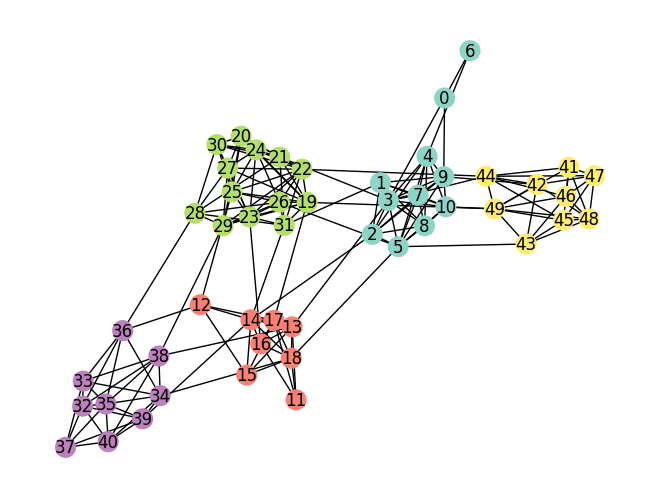

In [3]:
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)

# Gap statistics

In [4]:

def gap_statistic_best_num(posdf, nrefs=3, max_clusters=15):
        """
        Calculates KMeans optimal K using Gap Statistic 
        Param s:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
        Returns: (gaps, optimalK)
        """
        gaps = np.zeros((len(range(1, max_clusters)),))
        df_scores = pd.DataFrame({'clusterCount':[], 'gap':[]})
        for gap_index, k in enumerate(range(1, max_clusters)):
                # Holder for reference dispersion results
                refDisps = np.zeros(nrefs)
                # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
                for i in range(nrefs):
                        # Create new random reference set
                        randomReference = np.random.random_sample(size=posdf.shape)
                        # Fit to it
                        km = KMeans(k)
                        km.fit(randomReference)
                        
                        refDisp = km.inertia_
                        refDisps[i] = refDisp
                        # Fit cluster to original data and create dispersion
                km = KMeans(k)
                km.fit(posdf)
                
                origDisp = km.inertia_
                # Calculate gap statistic
                gap = np.log(np.mean(refDisps)) - np.log(origDisp)
                # Assign this loop's gap statistic to gaps
                gaps[gap_index] = gap
                
                new_row = pd.DataFrame({'clusterCount': [k], 'gap': [gap]})
                df_scores = pd.concat([df_scores, new_row], ignore_index=True)  
        
        return (gaps.argmax() + 1, df_scores)

In [7]:
import warnings
warnings.filterwarnings('ignore')
score_g, df = gap_statistic_best_num(posdf, nrefs=5, max_clusters=10)
print(score_g)

5


# Elbow method

In [9]:
from yellowbrick.cluster import KElbowVisualizer

def elbow_method_best_num(posdf, max_clusters=10):
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2, max_clusters), timings= True)
    # the plot kept showing under the results
    plt.ioff()
    visualizer.fit(posdf)
    plt.ion()       
    # visualizer.show()    
    scores = visualizer.k_scores_
    df_scores = pd.DataFrame({'k': range(2, max_clusters), 'score': scores})
    
    return(visualizer.elbow_value_, df_scores)

In [10]:
(best_num, df) = elbow_method_best_num(posdf)
print(best_num)
print(df)

5
   k     score
0  2  8.575825
1  3  5.330526
2  4  3.347461
3  5  2.265111
4  6  2.045821
5  7  1.768758
6  8  1.619599
7  9  1.359679


# Silhouette 

In [11]:
from yellowbrick.cluster import KElbowVisualizer

def silhouette_best_num(posdf, max_clusters=10):
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2, max_clusters),metric='silhouette', timings= True)
    plt.ioff()
    visualizer.fit(posdf)
    plt.ion()        
    # visualizer.show() 
    scores = visualizer.k_scores_
    df_scores = pd.DataFrame({'k': range(2, max_clusters), 'score': scores})
    
    return(visualizer.elbow_value_, df_scores)

In [12]:
(best_num, df) = silhouette_best_num(posdf)
print(best_num)
print(df)

4
   k     score
0  2  0.396494
1  3  0.411795
2  4  0.450881
3  5  0.363620
4  6  0.388625
5  7  0.360497
6  8  0.352526
7  9  0.304210


# Calinski-Harabasz Index

In [14]:
#  Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

def calinski_harabasz_best_num(posdf, max_clusters=10):
    model = KMeans()
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2, max_clusters), metric='calinski_harabasz', timings= True)
    plt.ioff()
    visualizer.fit(posdf)        # Fit the data to the visualizer
    plt.ion()        
    # visualizer.show() 
    scores = visualizer.k_scores_
    df_scores = pd.DataFrame({'k': range(2, max_clusters), 'score': scores})
    
    return(visualizer.elbow_value_, df_scores)       

In [15]:
calinski_harabasz_best_num(posdf)

(np.int64(4),
    k      score
 0  2  42.463218
 1  3  47.474387
 2  4  60.216682
 3  5  49.993402
 4  6  60.062669
 5  7  53.506607
 6  8  54.716104
 7  9  52.359164)

# BIC for GMM

In [17]:

#todo przemyslec czy tego uzywac w ogóle
from sklearn.mixture import GaussianMixture

n_components = range(2, 10)
# covariance_type = ['spherical', 'tied', 'diag', 'full']
covariance_type = ['tied', 'diag', 'full']

score = []

for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov)
        gmm.fit(posdf)
        score.append((cov, n_comp, gmm.bic(posdf)))

# Convert the score list to a DataFrame
df_scores = pd.DataFrame(score, columns=['covariance_type', 'n_components', 'bic'])

# Find the row with the minimum BIC score
min_bic_row = df_scores.loc[df_scores['bic'].idxmin()]

# Extract the optimal covariance type and number of components
optimal_covariance_type = min_bic_row['covariance_type']
optimal_n_components = min_bic_row['n_components']
optimal_bic = min_bic_row['bic']

print(f"The optimal covariance type is: {optimal_covariance_type}")
print(f"The optimal number of components is: {optimal_n_components}")
print(f"The lowest BIC score is: {optimal_bic}")

The optimal covariance type is: tied
The optimal number of components is: 3
The lowest BIC score is: 121.9162258379165
